# Analyse the syntetic data

In [6]:
# Config path
synthetic_data_path = 'output/synthetic_data.json'

## Synthetic data question lenght

The distrubution of length the generator was told to generate

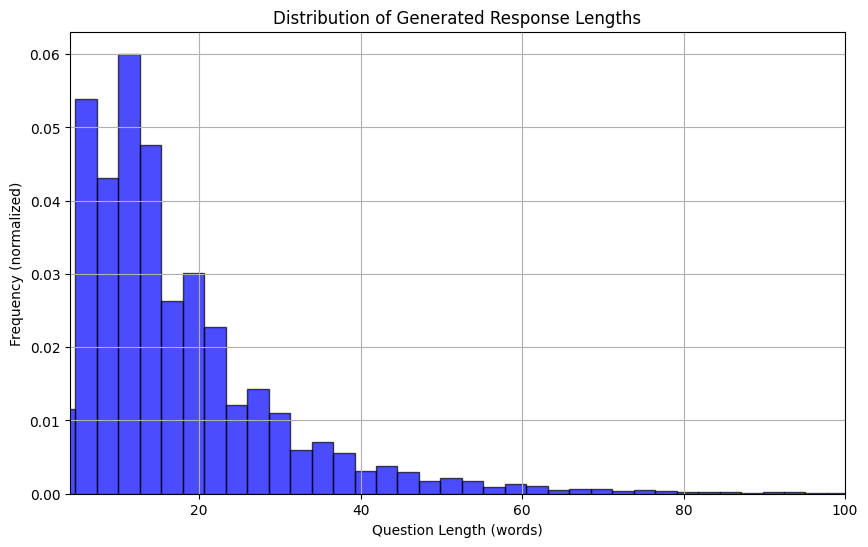

In [2]:
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
from data_generator import generate_response_length

# Generate samples
samples = [generate_response_length() for _ in range(100000)]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=100, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title('Distribution of Generated Response Lengths')
plt.xlabel('Question Length (words)')
plt.ylabel('Frequency (normalized)')
plt.xlim(4, 100)
plt.grid(True)
plt.show()

The actual distrubution of question lenght

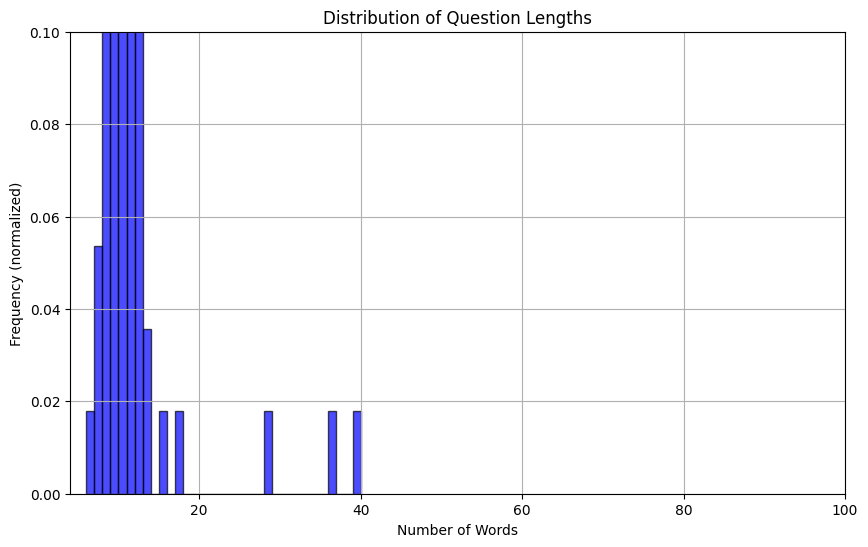

In [12]:
import json
import matplotlib.pyplot as plt

# Load questions from the JSON file
with open(synthetic_data_path, 'r') as f:
    questions = json.load(f)

# Count the number of words in each question
word_counts = [len(question.split()) for question in questions]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=range(min(word_counts), max(word_counts) + 1), color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency (normalized)')
plt.xlim(4, 100)  # Set x-axis limits to match the previous plot
plt.ylim(0, 0.1)  # Set y-axis limits to match the previous plot
plt.grid(True)
plt.show()

## Token frequenzy analyses

In [44]:
import json
from collections import Counter
import tiktoken

# Load the data from synthetic_data.json
with open(synthetic_data_path, 'r') as file:
    data = json.load(file)

# Concatenate all questions into a single string
text = ' '.join(data)

# Initialize the tiktoken tokenizer
tokenizer = tiktoken.get_encoding("o200k_base")

# Tokenize the text using tiktoken
token_ids = tokenizer.encode(text)

# Decode token IDs to token strings
tokens = [tokenizer.decode([token_id]) for token_id in token_ids]

# Count the frequency of each token in your data
frequency = Counter(tokens)

# Get the token ranks (lower token ID generally means higher frequency)
token_ranks = {token: rank for rank, token in enumerate(sorted(token_ids))}

# Normalize your frequencies using the inverse of the token rank
normalized_frequency = {}
for token, count in frequency.items():
    rank = token_ranks.get(token, tokenizer.n_vocab)
    inverse_rank = 1 / (rank + 1)  # Add 1 to avoid division by zero
    normalized_frequency[token] = count * inverse_rank

# Display the normalized token frequencies
#for token, norm_freq in sorted(normalized_frequency.items(), key=lambda x: x[1], reverse=True):
#    print(f'{token}: {norm_freq}')

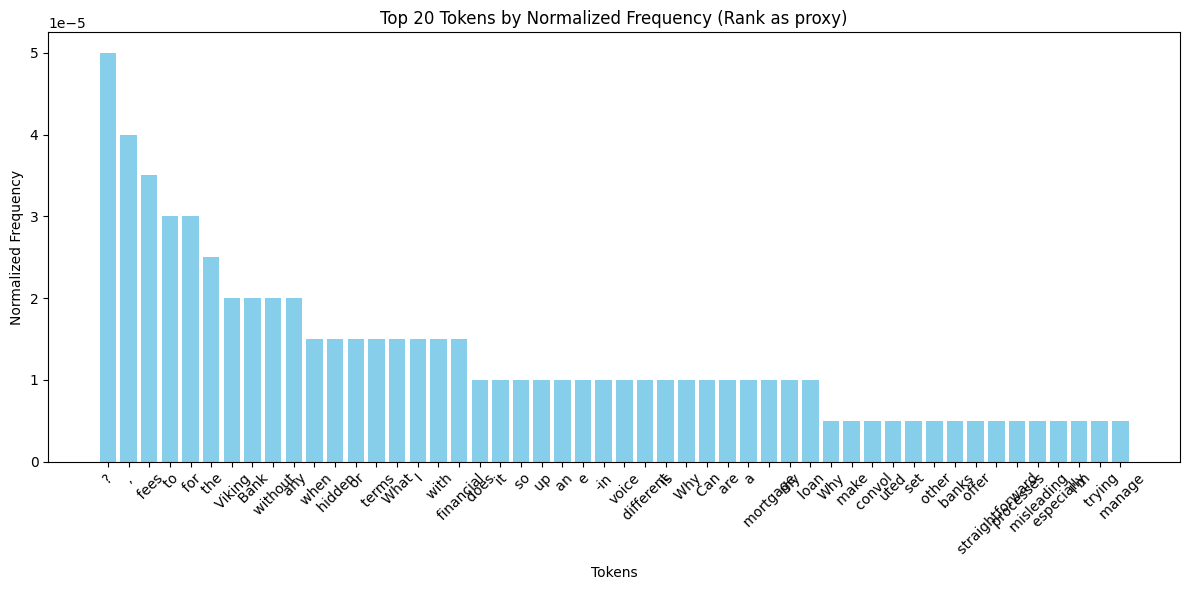

In [45]:
import matplotlib.pyplot as plt

# Select top 20 tokens based on normalized frequency
top_tokens = sorted(normalized_frequency.items(), key=lambda x: x[1], reverse=True)[:50]
tokens, frequencies = zip(*top_tokens)

# Plot the normalized frequencies
plt.figure(figsize=(12, 6))
plt.bar(tokens, frequencies, color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('Normalized Frequency')
plt.title('Top 20 Tokens by Normalized Frequency (Rank as proxy)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
import json
from collections import Counter
import nltk
from nltk.corpus import brown

# Download the Brown corpus if not already downloaded 
nltk.download('brown')

# Load the data from synthetic_data.json
with open(synthetic_data_path, 'r') as file:
    data = json.load(file)

# Concatenate all questions into a single string
text = ' '.join(data)

# Split the text into words
words = text.split()

# Count the frequency of each word in the data
frequency = Counter(words)

# Get general word frequencies from the Brown corpus
general_freq = Counter(word.lower() for word in brown.words())

# Get the word ranks based on data frequency
sorted_words = sorted(frequency.items(), key=lambda x: x[1], reverse=True)
word_ranks = {word: rank for rank, (word, _) in enumerate(sorted_words)}

# Normalize frequencies using inverse of rank and general frequency
normalized_frequency = {}
for word, count in frequency.items():
    rank = word_ranks.get(word, len(frequency))
    inverse_rank = 1 / (rank + 1)  # Add 1 to avoid division by zero
    general_frequency = general_freq.get(word.lower(), 1)
    normalized_frequency[word] = (count * inverse_rank) / general_frequency

# Display the normalized word frequencies
#for word, norm_freq in sorted(normalized_frequency.items(), key=lambda x: x[1], reverse=True):
#    print(f'{word}: {norm_freq}')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\albinlnnflt\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


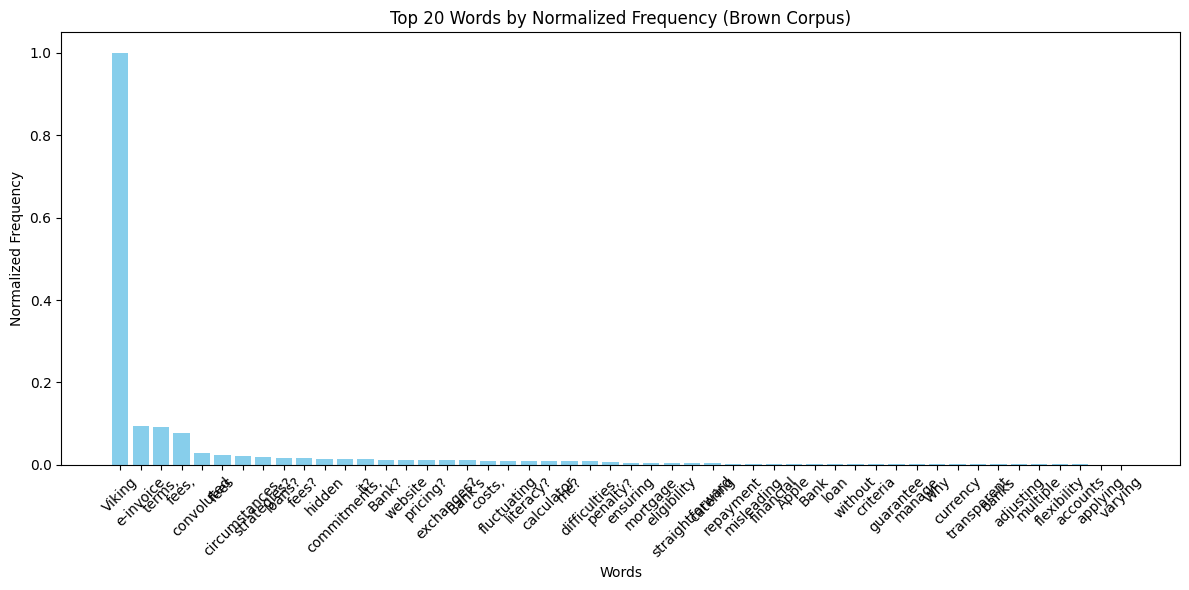

In [47]:
import matplotlib.pyplot as plt

# Select top 20 words based on normalized frequency
top_words = sorted(normalized_frequency.items(), key=lambda x: x[1], reverse=True)[:50]
words, frequencies = zip(*top_words)

# Plot the normalized frequencies
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Normalized Frequency')
plt.title('Top 20 Words by Normalized Frequency (Brown Corpus)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Vizualisation of synthetic data

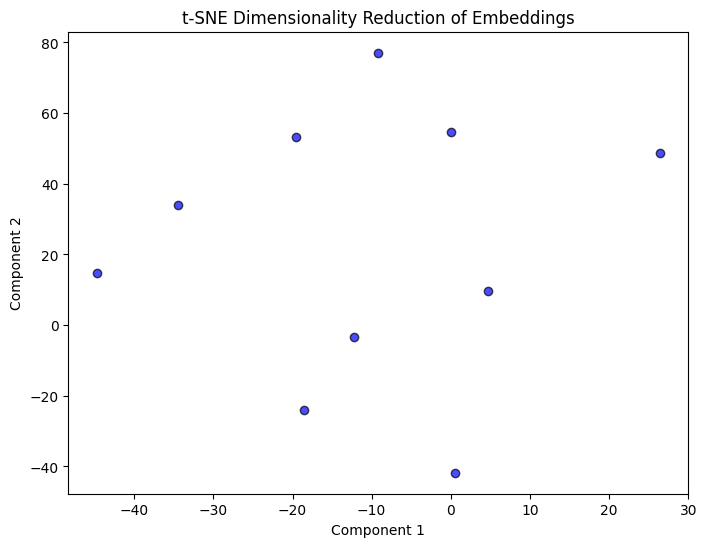

In [ ]:
import os
from openai import AzureOpenAI

# Set up Azure OpenAI API credentials
client = AzureOpenAI(
    api_version="2023-07-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_KEY")
)

response = client.embeddings.create(
    input=data,
    model=os.getenv("AZURE_OPENAI_EMBEDDINGMODEL")  # Refer to the deployment name from .env file
)

embeddings = [item.embedding for item in response.data]

import numpy as np
from sklearn.manifold import TSNE

# Convert embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Initialize t-SNE with 2 components for visualization
tsne = TSNE(n_components=2, perplexity=5, random_state=42) # Tune the perplexity value to get good results
reduced_embeddings = tsne.fit_transform(embeddings_array)

import matplotlib.pyplot as plt

# Plot the reduced embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', edgecolor='k', alpha=0.7)
plt.title('t-SNE Dimensionality Reduction of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Shannon Entropy

Shannon Entropy is a metric used to quantify the diversity or unpredictability within a dataset. Specifically, it measures the average amount of information produced by a stochastic source of data, such as words in a text corpus.

What It Shows:

**Unpredictability:** Higher entropy indicates a more uniform distribution of elements (e.g., words), meaning each element is equally likely and the dataset is highly unpredictable.
**Diversity:** Lower entropy suggests that certain elements dominate the dataset, reflecting less diversity and higher predictability.
Interpreting the Number:

**Higher Values:** Suggest greater diversity and unpredictability. For example, a text with a wide variety of unique words will have higher entropy.
**Lower Values:** Indicate limited diversity with repetitive or common elements being more frequent.
Understanding Shannon Entropy helps in assessing the complexity and richness of data, aiding in tasks like text analysis, cryptography, and information theory applications.

#### Minimum and Maximum Values for Shannon Entropy

**Minimum Entropy (0):**

- **Definition:** Occurs when the dataset has no diversity.
- **Scenario:** All elements are identical, making the outcome completely predictable.
- **Interpretation:** Entropy is 0, indicating no uncertainty or randomness in the data distribution.

**Maximum Entropy (log₂ N):**

**Definition:** Achieved when the dataset is perfectly uniform.
**Scenario:** Each of the N unique elements occurs with equal probability.
**Interpretation:** Entropy reaches its highest value of log₂ N, reflecting maximum uncertainty and diversity in the data.

In [51]:
import math
from collections import Counter

def calculate_shannon_entropy(data):
    counts = Counter(data)
    total = sum(counts.values())
    entropy = -sum((count/total) * math.log2(count/total) for count in counts.values())
    return entropy

# Example usage:
# Load the data from synthetic_data.json
with open(synthetic_data_path, 'r') as file:
    data = json.load(file)

entropy = calculate_shannon_entropy(data)
print(f"Shannon Entropy: {entropy}")

# Calculate maximum Shannon Entropy
unique_words = set()
for s in data:
    unique_words.update(s.split())

max_entropy = math.log2(len(unique_words))
print(f"Maximum Shannon Entropy: {max_entropy}")

Shannon Entropy: 3.321928094887362
Maximum Shannon Entropy: 7.03342300153745
